# Object Detection with DETR - a minimal implementation

In this notebook we show a demo of DETR (Detection Transformer), with slight differences with the baseline model in the paper.

We show how to define the model, load pretrained weights and visualize bounding box and class predictions.

Let's start with some common imports.

In [4]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

## DETR
Here is a minimal implementation of DETR:

In [5]:
class DETRdemo(nn.Module):
    """
    Demo DETR implementation.

    Demo implementation of DETR in minimal number of lines, with the
    following differences wrt DETR in the paper:
    * learned positional encoding (instead of sine)
    * positional encoding is passed at input (instead of attention)
    * fc bbox predictor (instead of MLP)
    The model achieves ~40 AP on COCO val5k and runs at ~28 FPS on Tesla V100.
    Only batch size 1 supported.
    """
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()

        #The second line del self.backbone.fc removes the fully connected (fc) layer from the ResNet-50 model. 
        #The fully connected layer is typically used for classification tasks, but in the context of object detection, 
        #it is not needed. By removing this layer, the backbone will output feature maps instead of class probabilities, 
        #which is more suitable for the object detection task.
        del self.backbone.fc

        

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)  #hidden=256

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        #input:[1,3,800,1066]
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        #[1,2048,25,34]

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)
        #[1,256,25,34]
        
        # construct positional encodings
        H, W = h.shape[-2:]  #H=25,  W=34
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)

        # finally project transformer outputs to class labels and bounding boxes
        return {'pred_logits': self.linear_class(h),
                'pred_boxes': self.linear_bbox(h).sigmoid()}

As you can see, DETR architecture is very simple, thanks to the representational power of the Transformer. There are two main components:
* a convolutional backbone - we use ResNet-50 in this demo
* a Transformer - we use the default PyTorch nn.Transformer


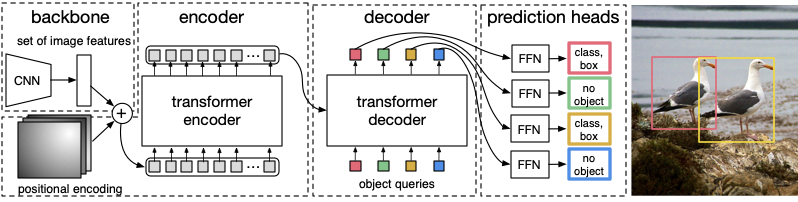

Let's construct the model with 80 COCO output classes + 1 ⦰ "no object" class and load the pretrained weights.
The weights are saved in half precision to save bandwidth without hurting model accuracy.

In [47]:
test1=torch.tensor([1,2,3],dtype=torch.float32)
print(f"test1:  {test1}")
print(f"after passing Parameter:   {nn.Parameter(test1)}")

test1:  tensor([1., 2., 3.])
after passing Parameter:   Parameter containing:
tensor([1., 2., 3.], requires_grad=True)


In [37]:
row1 = nn.Parameter(torch.rand(50, 256 // 2))
row1

Parameter containing:
tensor([[0.0489, 0.9794, 0.6224,  ..., 0.0875, 0.0776, 0.0957],
        [0.1419, 0.0885, 0.2687,  ..., 0.0078, 0.2234, 0.8321],
        [0.1400, 0.7696, 0.3623,  ..., 0.0495, 0.2840, 0.8079],
        ...,
        [0.4210, 0.2442, 0.4234,  ..., 0.8183, 0.6682, 0.5362],
        [0.7498, 0.2277, 0.8394,  ..., 0.1539, 0.5825, 0.7441],
        [0.3565, 0.6208, 0.0430,  ..., 0.8167, 0.9604, 0.4077]],
       requires_grad=True)

In [48]:
row1.shape

torch.Size([50, 128])

In [63]:
W=34
H=25

In [64]:
row1[:W,...].shape

torch.Size([34, 128])

In [65]:
row1[:W].unsqueeze(0).shape

torch.Size([1, 34, 128])

In [75]:
row1[:W].unsqueeze(0).repeat(H, 1, 1).shape

torch.Size([25, 34, 128])

In [62]:
col1 = nn.Parameter(torch.rand(50, 256 // 2))

In [73]:
col1.shape

torch.Size([50, 128])

In [69]:
col1[:H].shape

torch.Size([25, 128])

In [71]:
col1[:H].unsqueeze(1).shape

torch.Size([25, 1, 128])

In [72]:
col1[:H].unsqueeze(1).repeat(1, W, 1).shape

torch.Size([25, 34, 128])

In [80]:
pos = torch.cat([
            col1[:W].unsqueeze(0).repeat(H, 1, 1),
            row1[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1)

In [114]:
pos=pos.unsqueeze(1)

In [115]:
pos.shape

torch.Size([25, 1, 34, 256])

In [82]:
row1[:W].unsqueeze(0).repeat(H, 1, 1)[0][0]

tensor([0.0489, 0.9794, 0.6224, 0.5693, 0.9558, 0.5195, 0.0805, 0.8469, 0.0976,
        0.2121, 0.9519, 0.6061, 0.7724, 0.9131, 0.2846, 0.7903, 0.6278, 0.2224,
        0.5592, 0.9757, 0.7252, 0.7499, 0.2852, 0.6203, 0.0693, 0.2636, 0.3285,
        0.6078, 0.6215, 0.6503, 0.4741, 0.6844, 0.7233, 0.1976, 0.3333, 0.9465,
        0.4063, 0.7569, 0.2439, 0.1323, 0.6961, 0.1399, 0.5284, 0.4166, 0.7468,
        0.3628, 0.9892, 0.1339, 0.4408, 0.6251, 0.0313, 0.0361, 0.1708, 0.7463,
        0.3148, 0.6684, 0.6835, 0.9348, 0.8430, 0.2804, 0.3911, 0.1990, 0.3918,
        0.5782, 0.1132, 0.8707, 0.4103, 0.5970, 0.1715, 0.5061, 0.3196, 0.5048,
        0.0594, 0.1919, 0.4712, 0.0505, 0.8143, 0.5133, 0.1656, 0.3806, 0.6435,
        0.5907, 0.3214, 0.7216, 0.8419, 0.6034, 0.9298, 0.6557, 0.4280, 0.9502,
        0.0241, 0.9130, 0.6004, 0.6895, 0.5065, 0.7120, 0.1853, 0.8205, 0.2138,
        0.1549, 0.1788, 0.2746, 0.2003, 0.6220, 0.2839, 0.4112, 0.6591, 0.6726,
        0.7523, 0.5308, 0.1214, 0.9746, 

In [83]:
col1[:H].unsqueeze(1).repeat(1, W, 1)[0][0]

tensor([0.0792, 0.3162, 0.9338, 0.3038, 0.5517, 0.4962, 0.8925, 0.9986, 0.9721,
        0.8965, 0.6443, 0.9890, 0.1358, 0.4716, 0.0302, 0.2491, 0.9252, 0.5874,
        0.0549, 0.0487, 0.7647, 0.7342, 0.5640, 0.6171, 0.7599, 0.4583, 0.5165,
        0.5366, 0.6958, 0.2854, 0.2942, 0.6561, 0.5956, 0.4440, 0.1015, 0.9106,
        0.1223, 0.5600, 0.4681, 0.6680, 0.1336, 0.8446, 0.8388, 0.1428, 0.2064,
        0.4358, 0.9640, 0.3953, 0.2457, 0.8742, 0.2922, 0.8433, 0.3853, 0.0856,
        0.6173, 0.9117, 0.3657, 0.6405, 0.9402, 0.4138, 0.5303, 0.4527, 0.3762,
        0.0112, 0.2279, 0.6482, 0.0135, 0.2939, 0.9507, 0.7960, 0.6177, 0.5392,
        0.5225, 0.1068, 0.4552, 0.3939, 0.7538, 0.1919, 0.4459, 0.8722, 0.0494,
        0.5495, 0.4727, 0.0473, 0.5735, 0.6991, 0.8754, 0.1274, 0.1093, 0.3837,
        0.6209, 0.0593, 0.1325, 0.8301, 0.4153, 0.2046, 0.3858, 0.6040, 0.9737,
        0.2682, 0.3459, 0.3051, 0.0196, 0.3990, 0.9689, 0.2521, 0.8533, 0.6400,
        0.2755, 0.1245, 0.1644, 0.2327, 

In [84]:
pos[0][0]

tensor([0.0792, 0.3162, 0.9338, 0.3038, 0.5517, 0.4962, 0.8925, 0.9986, 0.9721,
        0.8965, 0.6443, 0.9890, 0.1358, 0.4716, 0.0302, 0.2491, 0.9252, 0.5874,
        0.0549, 0.0487, 0.7647, 0.7342, 0.5640, 0.6171, 0.7599, 0.4583, 0.5165,
        0.5366, 0.6958, 0.2854, 0.2942, 0.6561, 0.5956, 0.4440, 0.1015, 0.9106,
        0.1223, 0.5600, 0.4681, 0.6680, 0.1336, 0.8446, 0.8388, 0.1428, 0.2064,
        0.4358, 0.9640, 0.3953, 0.2457, 0.8742, 0.2922, 0.8433, 0.3853, 0.0856,
        0.6173, 0.9117, 0.3657, 0.6405, 0.9402, 0.4138, 0.5303, 0.4527, 0.3762,
        0.0112, 0.2279, 0.6482, 0.0135, 0.2939, 0.9507, 0.7960, 0.6177, 0.5392,
        0.5225, 0.1068, 0.4552, 0.3939, 0.7538, 0.1919, 0.4459, 0.8722, 0.0494,
        0.5495, 0.4727, 0.0473, 0.5735, 0.6991, 0.8754, 0.1274, 0.1093, 0.3837,
        0.6209, 0.0593, 0.1325, 0.8301, 0.4153, 0.2046, 0.3858, 0.6040, 0.9737,
        0.2682, 0.3459, 0.3051, 0.0196, 0.3990, 0.9689, 0.2521, 0.8533, 0.6400,
        0.2755, 0.1245, 0.1644, 0.2327, 

In [116]:
pos.shape

torch.Size([25, 1, 34, 256])

In [88]:
pos.flatten(0, 1).shape

torch.Size([850, 256])

In [89]:
pos.flatten(0, 1).unsqueeze(1).shape

torch.Size([850, 1, 256])

In [90]:
h = nn.Parameter(torch.rand(1,256,25,34))

In [91]:
h.shape

torch.Size([1, 256, 25, 34])

In [103]:
h.flatten(3).shape

torch.Size([1, 256, 25, 34])

In [111]:
h.flatten(2).permute(2, 0, 1).shape

torch.Size([850, 1, 256])

In [105]:
query_pos = nn.Parameter(torch.rand(100, 256))
query_pos.shape

torch.Size([100, 256])

In [106]:
query_pos.unsqueeze(1).shape

torch.Size([100, 1, 256])

In [109]:
query_pos.unsqueeze(1).transpose(0, 1).shape


torch.Size([1, 100, 256])

In [118]:
a=pos + 0.1 * h.flatten(2).permute(2, 0, 1)

In [119]:
a.shape

torch.Size([25, 850, 34, 256])

In [124]:
e1=MLP(256,3,3)

NameError: name 'MLP' is not defined

In [122]:
e1

Linear(in_features=256, out_features=3, bias=True)

In [6]:
detr = DETRdemo(num_classes=91)
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
detr.load_state_dict(state_dict)
detr.eval();

C:\Users\tony8\anaconda3\envs\ece285hw\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## Computing predictions with DETR

The pre-trained DETR model that we have just loaded has been trained on the 80 COCO classes, with class indices ranging from 1 to 90 (that's why we considered 91 classes in the model construction).
In the following cells, we define the mapping from class indices to names.

In [7]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

DETR uses standard ImageNet normalization, and output boxes in relative image coordinates in $[x_{\text{center}}, y_{\text{center}}, w, h]$ format, where $[x_{\text{center}}, y_{\text{center}}]$ is the predicted center of the bounding box, and $w, h$ its width and height. Because the coordinates are relative to the image dimension and lies between $[0, 1]$, we convert predictions to absolute image coordinates and $[x_0, y_0, x_1, y_1]$ format for visualization purposes.

In [8]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

Let's put everything together in a `detect` function:

In [9]:
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)  #torch.Size([3, 800, 1066])--->torch.Size([1, 3, 800, 1066])

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)    #detr(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

## Using DETR
To try DETRdemo model on your own image just change the URL below.

In [24]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
#url='https://plus.unsplash.com/premium_photo-1667382050215-6df445b0d3fa?q=80&w=1926&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D'
im = Image.open(requests.get(url, stream=True).raw)

scores, boxes = detect(im, detr, transform)

In [25]:
img = transform(im)
img.shape


torch.Size([3, 800, 1066])

In [26]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 800, 1066])

In [28]:
from torchinfo import summary

In [34]:
random_input_image = (1, 3, 800, 1066)

In [35]:
# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(DETRdemo(num_classes=91),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
DETRdemo (DETRdemo)                                               [1, 3, 800, 1066]    [1, 100, 4]          38,400               True
├─ResNet (backbone)                                               --                   --                   --                   True
│    └─Conv2d (conv1)                                             [1, 3, 800, 1066]    [1, 64, 400, 533]    9,408                True
│    └─BatchNorm2d (bn1)                                          [1, 64, 400, 533]    [1, 64, 400, 533]    128                  True
│    └─ReLU (relu)                                                [1, 64, 400, 533]    [1, 64, 400, 533]    --                   --
│    └─MaxPool2d (maxpool)                                        [1, 64, 400, 533]    [1, 64, 200, 267]    --                   --
│    └─Sequential (layer1)                                   

Let's now visualize the model predictions

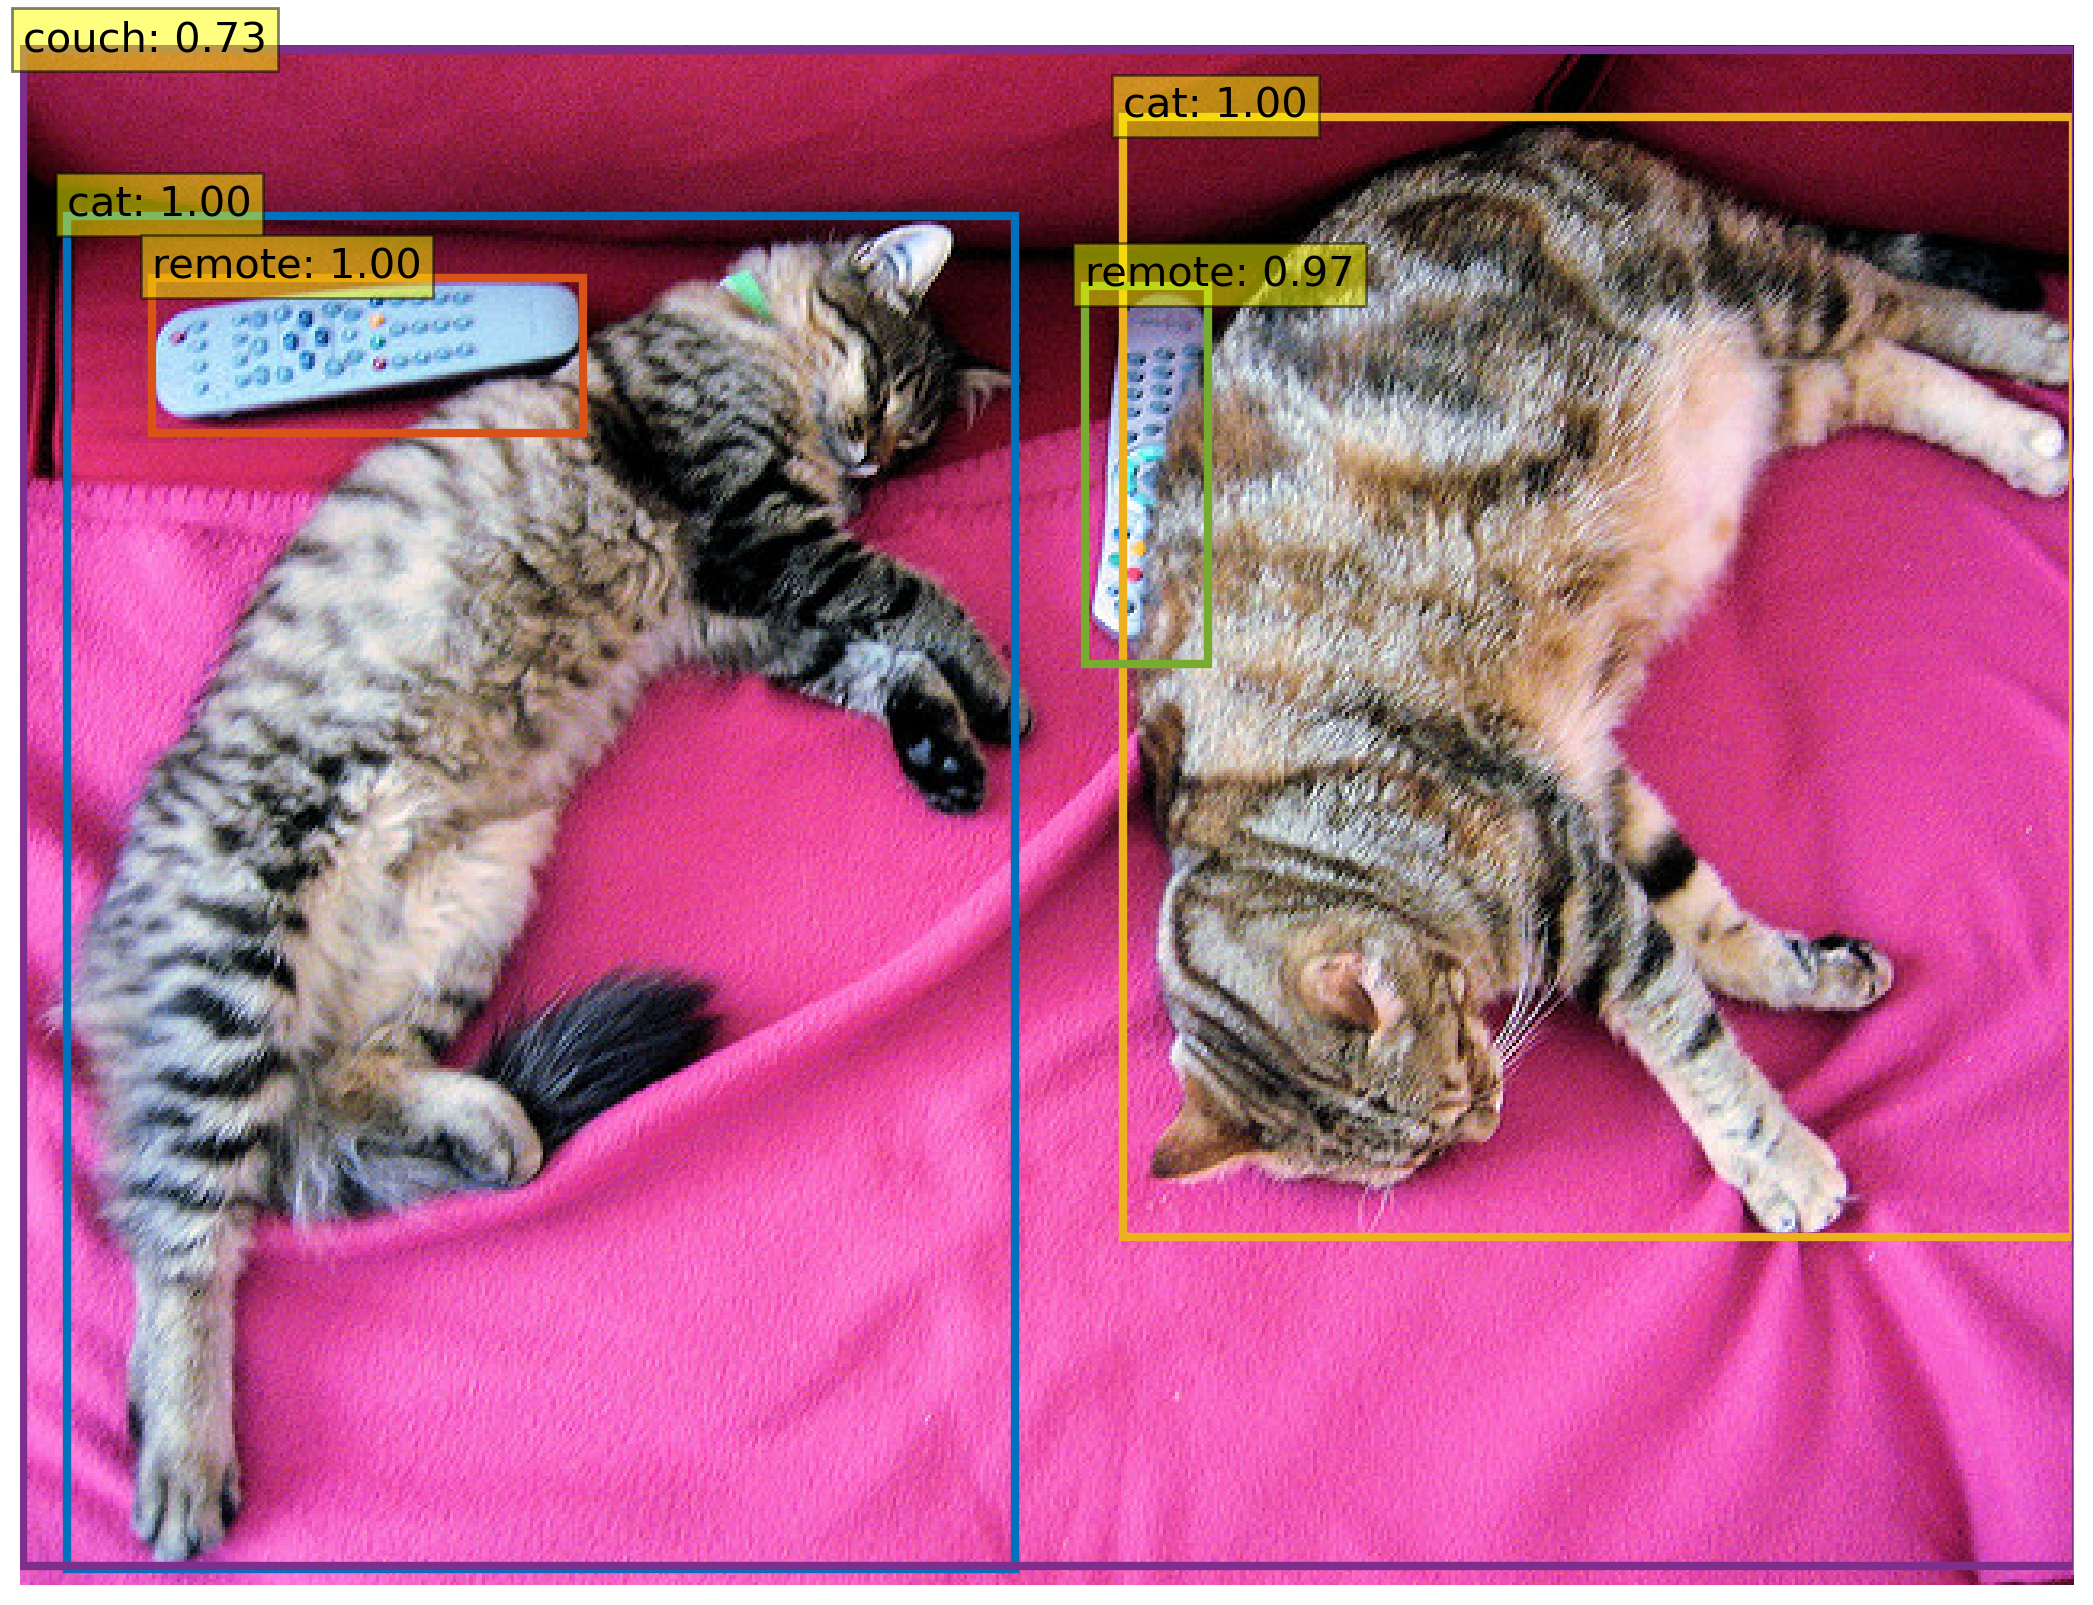

In [14]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

plot_results(im, scores, boxes)

In [1]:
ax = plt.gca()
for p, (xmin, ymin, xmax, ymax), c in zip(scores, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))

NameError: name 'plt' is not defined

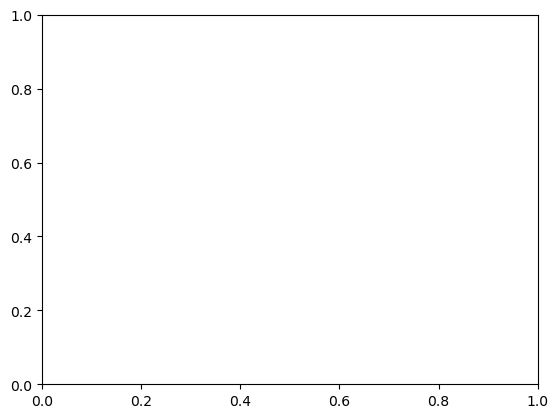

In [3]:
ax = plt.gca()

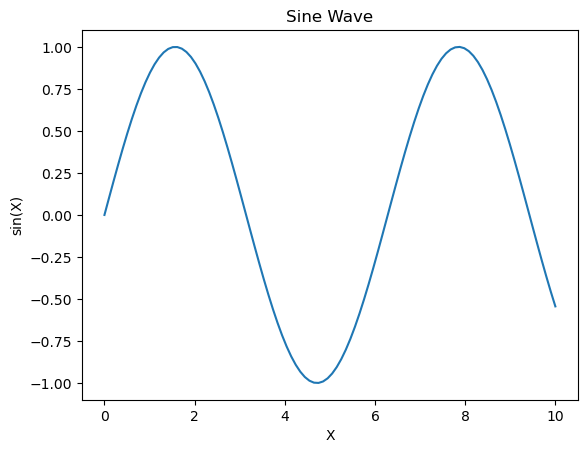

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Create some data
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the data
ax.plot(x, y)

# Add labels and a title
ax.set_xlabel('X')
ax.set_ylabel('sin(X)')
ax.set_title('Sine Wave')

# Display the plot
plt.show()

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
